In [1]:
import pandas as pd
from scipy.stats import qmc
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

from pathlib import Path

In [2]:
directory_path = Path.cwd()

In [3]:
dataset_file_name = 'rubber_cb_vf_dataset_AB03_100_test_cases.csv'

In [4]:
exps_file = 'doe_rubber_cb_all_vf_test.csv'

df = pd.read_csv(directory_path / exps_file).drop(columns=['Unnamed: 0'])
df[['F11']] = df[['dU11']] + 1.0
df[['F12']] = df[['dU12']]
df[['F21']] = df[['dU21']]
df[['F22']] = df[['dU22']] + 1.0
df.drop(columns=['dU11', 'dU12', 'dU21', 'dU22'], inplace=True)

exps = df
vfrac_dict = {0.1: 0.0980,
              0.2: 0.1944,
              0.3: 0.2916,
              0.4: 0.3932,
              0.5: 0.4904,}
# create a volume fraction column replace the values with the dictionary
# rename the column to vol_frac

exps['vol_frac'] = exps['vol_req'].replace(vfrac_dict)
exps.drop(columns=['vol_req'], inplace=True)

In [5]:
exps

,seed,test,F11,F12,F21,F22,vol_frac
0,10,uniaxial,0.632456,0.000000,0.000000,1.000000,0.0980
1,10,uniaxial,0.648606,0.000000,0.000000,1.000000,0.0980
2,10,uniaxial,0.664364,0.000000,0.000000,1.000000,0.0980
3,10,uniaxial,0.679757,0.000000,0.000000,1.000000,0.0980
4,10,uniaxial,0.694808,0.000000,0.000000,1.000000,0.0980
...,...,...,...,...,...,...,...
495,50,shear,0.965620,0.259958,0.259958,0.965620,0.4904
496,50,shear,0.961810,0.273719,0.273719,0.961810,0.4904
497,50,shear,0.957730,0.287670,0.287670,0.957730,0.4904
498,50,shear,0.953361,0.301832,0.301832,0.953361,0.4904


In [6]:
def_grad_doe = exps[['F11', 'F12', 'F21', 'F22']].values.reshape(-1, 2, 2)

vol_frac_doe = exps['vol_frac'].values

test_doe = exps['test'].values

samples_path = Path('outputs/563097.hpc06.hpc/Data/')

n_experiments = len(exps)

In [7]:
def pk2_stress(deformation_gradient, pk1_stress):
    return jnp.matmul(jnp.linalg.inv(deformation_gradient), pk1_stress)

In [8]:
def gl_strain(deformation_gradient):
    C = deformation_gradient.T @ deformation_gradient
    E = 0.5 * (C - jnp.eye(2))
    return E

In [9]:
raw_data = pd.DataFrame(columns=['F11', 'F12', 'F21', 'F22', 'P11', 'P12', 'P21', 'P22', 'vol_frac', 'test'])
idx = 0
for i in range(n_experiments):
    experiment_folder = samples_path / f'point_{i}'
    result_file = experiment_folder / Path('results.p')

    try:
        result = pd.read_pickle(result_file)

        # get the deformation gradient and pk1 stress
        F = result['deformation_gradient'][-1]
        P = result['pk1_stress'][-1]
        raw_data.loc[i] = [F[0,0], F[0,1], F[1,0], F[1,1], P[0,0], P[0,1], P[1,0], P[1,1], vol_frac_doe[i], test_doe[i]]
        idx += 1

    except FileNotFoundError:
        print(idx, "No data")
        raw_data.loc[idx] = [0.0]*8 + [vol_frac_doe[i]]
        idx += 1

In [10]:
raw_data

,F11,F12,F21,F22,P11,P12,P21,P22,vol_frac,test
0,0.632456,-2.853521e-38,-4.161230e-38,1.000000,-1.984273,0.001405,0.000889,-0.933421,0.0980,uniaxial
1,0.648606,-2.589153e-38,-3.984295e-38,1.000000,-1.855105,0.001250,0.000810,-0.899699,0.0980,uniaxial
2,0.664364,-2.349225e-38,-3.810991e-38,1.000000,-1.735184,0.001112,0.000739,-0.866263,0.0980,uniaxial
3,0.679757,-2.130765e-38,-3.640851e-38,1.000000,-1.623360,0.000990,0.000673,-0.833071,0.0980,uniaxial
4,0.694808,-1.931324e-38,-3.473551e-38,1.000000,-1.518678,0.000881,0.000612,-0.800086,0.0980,uniaxial
...,...,...,...,...,...,...,...,...,...,...
495,0.965620,2.599580e-01,2.599580e-01,0.965620,-1.392236,1.034124,1.034768,-1.389844,0.4904,shear
496,0.961810,2.737190e-01,2.737190e-01,0.961810,-1.589572,1.162640,1.164766,-1.582100,0.4904,shear
497,0.957729,2.876700e-01,2.876700e-01,0.957729,-1.814023,1.311307,1.314878,-1.802136,0.4904,shear
498,0.953361,3.018320e-01,3.018320e-01,0.953361,-2.071180,1.484517,1.489271,-2.056164,0.4904,shear


In [11]:
def_grad = raw_data[['F11', 'F12', 'F21', 'F22']].values.reshape(-1, 2, 2)
pk1_simulated = raw_data[['P11', 'P12', 'P21', 'P22']].values.reshape(-1, 2, 2)

In [12]:
pk2_simulated = jax.vmap(pk2_stress)(def_grad, pk1_simulated)
gl_strain_simulated = jax.vmap(gl_strain)(def_grad)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
dataset = pd.DataFrame()
dataset['vol_frac'] = raw_data['vol_frac']
dataset['test'] = raw_data['test']
dataset['E11'] = gl_strain_simulated[:,0,0]
dataset['E22'] = gl_strain_simulated[:,1,1]
dataset['E12'] = gl_strain_simulated[:,0,1]
dataset['S11'] = pk2_simulated[:,0,0]
dataset['S22'] = pk2_simulated[:,1,1]
dataset['S12'] = 0.5*(pk2_simulated[:,0,1]+pk2_simulated[:,1,0])

In [14]:
dataset

,vol_frac,test,E11,E22,E12,S11,S22,S12
0,0.0980,uniaxial,-2.999997e-01,0.000000e+00,-2.982978e-38,-3.137409,-0.933421,0.001555
1,0.0980,uniaxial,-2.896551e-01,0.000000e+00,-2.831817e-38,-2.860141,-0.899699,0.001368
2,0.0980,uniaxial,-2.793102e-01,0.000000e+00,-2.685866e-38,-2.611798,-0.866263,0.001206
3,0.0980,uniaxial,-2.689652e-01,0.000000e+00,-2.544627e-38,-2.388147,-0.833071,0.001064
4,0.0980,uniaxial,-2.586209e-01,0.000000e+00,-2.407725e-38,-2.185752,-0.800086,0.000940
...,...,...,...,...,...,...,...,...
495,0.4904,shear,7.273798e-08,7.273798e-08,2.510206e-01,-1.865501,-1.862637,1.573109
496,0.4904,shear,9.376540e-08,9.376540e-08,2.632656e-01,-2.173348,-2.164210,1.827117
497,0.4904,shear,-9.205623e-08,-9.205623e-08,2.755100e-01,-2.535189,-2.520315,2.130300
498,0.4904,shear,-2.988373e-08,-2.988373e-08,2.877549e-01,-2.964181,-2.944921,2.495038


In [15]:
def check_isclose(matrix1, matrix2, atol=1e-2):
    return jnp.allclose(matrix1, matrix2, atol)

def check_symmetry(matrix):
    # we check the symmetry of the matrix by checking if the matrix is close to its transpose
    # we use a relative tolerance of 10% and an absolute tolerance of 0.01
    return jnp.allclose(matrix, matrix.T, rtol=0.1, atol=0.01)

In [16]:
incomplete_sim = jnp.array(jnp.where(jax.vmap(check_isclose)(def_grad, def_grad_doe) == False)).reshape(-1)

unsymmetric_pk2 = jnp.array(jnp.where(jax.vmap(check_symmetry)(pk2_simulated) == False)).reshape(-1)

In [17]:
exclude_list = jnp.unique(jnp.concatenate((incomplete_sim, unsymmetric_pk2)))
len(exclude_list)

25

In [18]:

dataset = dataset.drop(exclude_list).reset_index(drop=True).round(4)
dataset

,vol_frac,test,E11,E22,E12,S11,S22,S12
0,0.0980,uniaxial,-0.3000,0.0,-0.0000,-3.1374,-0.9334,0.0016
1,0.0980,uniaxial,-0.2897,0.0,-0.0000,-2.8601,-0.8997,0.0014
2,0.0980,uniaxial,-0.2793,0.0,-0.0000,-2.6118,-0.8663,0.0012
3,0.0980,uniaxial,-0.2690,0.0,-0.0000,-2.3881,-0.8331,0.0011
4,0.0980,uniaxial,-0.2586,0.0,-0.0000,-2.1858,-0.8001,0.0009
...,...,...,...,...,...,...,...,...
470,0.4904,shear,0.0000,0.0,0.2510,-1.8655,-1.8626,1.5731
471,0.4904,shear,0.0000,0.0,0.2633,-2.1733,-2.1642,1.8271
472,0.4904,shear,-0.0000,-0.0,0.2755,-2.5352,-2.5203,2.1303
473,0.4904,shear,-0.0000,-0.0,0.2878,-2.9642,-2.9449,2.4950


In [19]:
# create a dictionary of the dataset for uniaxial and shear test

uniaxial_dataset = dataset[dataset['test'] == 'uniaxial'].drop(columns=['test'])

# create a sub dictionary for different volume fractions
uniaxial_dict = {}
for vol_frac in uniaxial_dataset['vol_frac'].unique():
    uniaxial_dict[vol_frac] = uniaxial_dataset[uniaxial_dataset['vol_frac'] == vol_frac].drop(columns=['vol_frac'])

shear_dataset = dataset[dataset['test'] == 'shear'].drop(columns=['test'])

# create a sub dictionary for different volume fractions
shear_dict = {}
for vol_frac in shear_dataset['vol_frac'].unique():
    shear_dict[vol_frac] = shear_dataset[shear_dataset['vol_frac'] == vol_frac].drop(columns=['vol_frac'])

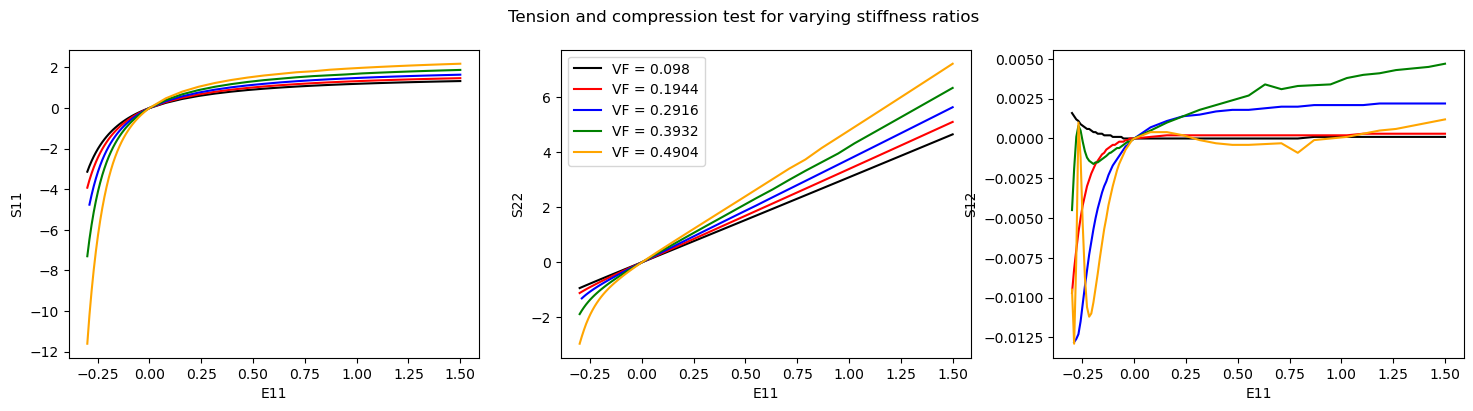

In [20]:
# plot the stress strain curve for the uniaxial test, for different volume fractions

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
line_styles = ['-', '-', '-', '-', '-']
colors = ['black', 'red', 'blue', 'green', 'orange']

for i, vol_frac in enumerate(uniaxial_dict.keys()):
    data = uniaxial_dict[vol_frac]
    ax[0,0].plot(data['E11'], data['S11'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])
    ax[0,1].plot(data['E11'], data['S22'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])
    ax[0,2].plot(data['E11'], data['S12'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])

fig.suptitle('Tension and compression test for varying volume fractions')
ax[0][0].set_xlabel('E11')
ax[0][0].set_ylabel('S11')
ax[0][1].set_xlabel('E11')
ax[0][1].set_ylabel('S22')
ax[0][2].set_xlabel('E11')
ax[0][2].set_ylabel('S12')
ax[0][1].legend()
plt.show()

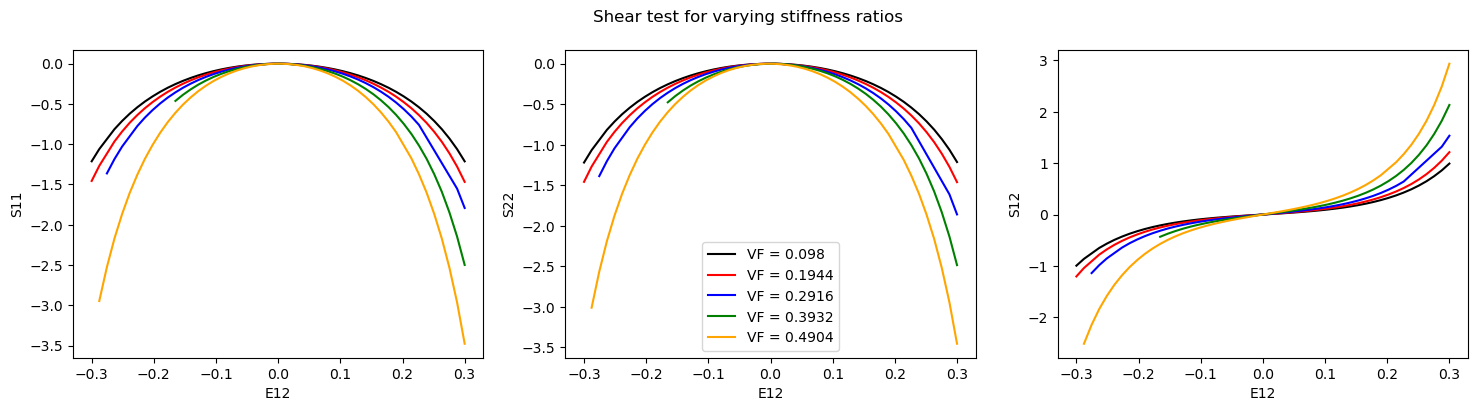

In [21]:
# plot the stress strain curve for the shear test, for different volume fractions

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(18, 4))
line_styles = ['-', '-', '-', '-', '-']
colors = ['black', 'red', 'blue', 'green', 'orange']

for i, vol_frac in enumerate(shear_dict.keys()):
    data = shear_dict[vol_frac]
    ax[0,0].plot(data['E12'], data['S11'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])
    ax[0,1].plot(data['E12'], data['S22'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])
    ax[0,2].plot(data['E12'], data['S12'], label=f'VF = {vol_frac}', linestyle=line_styles[i], color=colors[i])

fig.suptitle('Shear test for varying volume fractions')
ax[0][0].set_xlabel('E12')
ax[0][0].set_ylabel('S11')
ax[0][1].set_xlabel('E12')
ax[0][1].set_ylabel('S22')
ax[0][2].set_xlabel('E12')
ax[0][2].set_ylabel('S12')
ax[0][1].legend()
plt.show()


In [22]:
dataset.to_csv(directory_path / Path(dataset_file_name), index=False)